(5, 100)


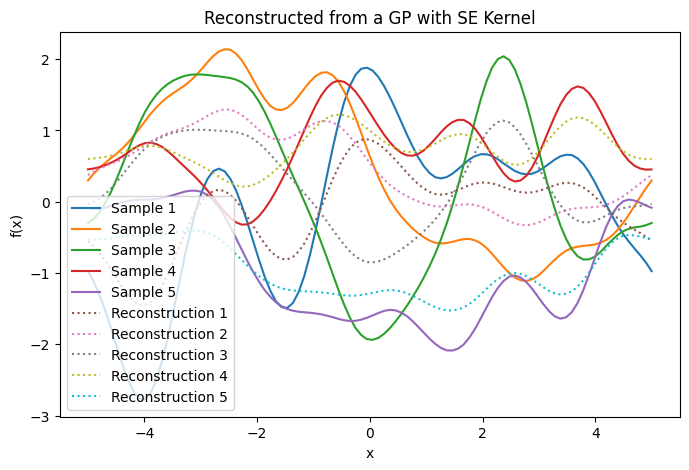

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Squared Exponential Kernel
def periodic_kernel(x1, x2, lengthscale=10.0, variance=1.0, period=1.0):
    """
    Compute the periodic kernel matrix.
    """
    dist = np.abs(np.subtract.outer(x1, x2))  # Compute |x - x'|
    return variance * np.exp(-2 * (np.sin(np.pi * dist / period) ** 2) / lengthscale**2)

# Sample from the GP prior
def sample_gp(n_samples=5, n_points=100, lengthscale=1.0, variance=1.0, noise=1e-6, n_modes=None, period=10):
    """
    Generate samples from a GP prior with an SE kernel.
    """
    if n_modes == None:
        n_modes = n_points

    x = np.linspace(-period/2, period/2, n_points)  # Input points
    K = periodic_kernel(x, x, lengthscale, variance, period=period)  # Compute covariance matrix
    K += noise * np.eye(n_points)  # Add a small noise term for numerical stability

    # Sample from multivariate normal
    samples = np.random.multivariate_normal(mean=np.zeros(n_points), cov=K, size=n_samples)

    # Plot the samples
    plt.figure(figsize=(8, 5))
    for i in range(n_samples):
        plt.plot(x, samples[i], label=f"Sample {i+1}")
    plt.title("Samples from a GP with SE Kernel")


    #Plot reconstruction after fft and ifft with n_point modes
    # Compute the Fourier transform of the samples
    samples_fft = np.fft.fft(samples, axis=1)
    samples_fft[:, n_modes:] = 0  # Zero out all modes above n_modes
    samples_reconstructed = np.fft.ifft(samples_fft, axis=1)

    print(samples_reconstructed.shape)

    for i in range(n_samples):
        plt.plot(x, samples_reconstructed[i], label=f"Reconstruction {i+1}", linestyle='dotted')
    plt.title("Reconstructed from a GP with SE Kernel")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.show()




# Run the function
sample_gp(n_samples=5, lengthscale=0.5, variance=1.0, n_modes=50)






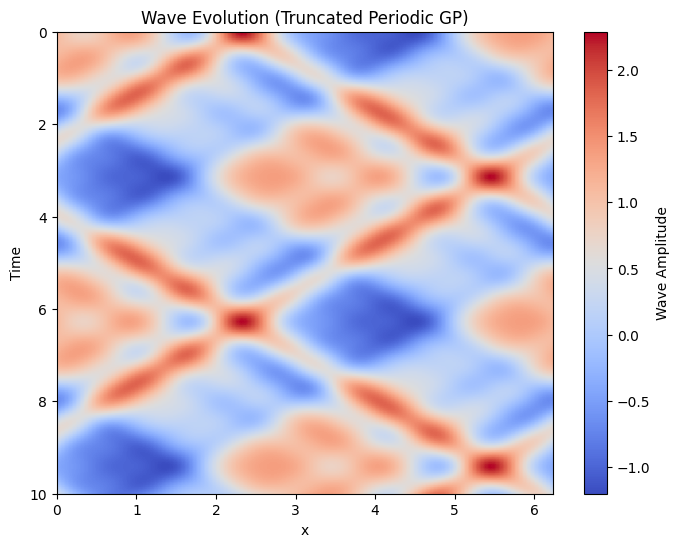

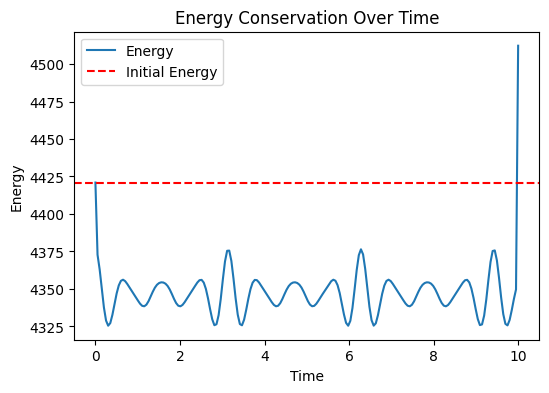

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters
L = 2 * np.pi  # Domain length
Nx = 128       # Number of spatial points
Nt = 200       # Number of time points
c = 1.0        # Wave speed
num_modes = 100  # Number of Fourier modes to keep

# Spatial and time grids
x_vals = np.linspace(0, L, Nx, endpoint=False)
t_vals = np.linspace(0, 10, Nt)

# -------------------------------
# Step 1: Sample Initial Periodic GP
# -------------------------------

def periodic_kernel(x1, x2, lengthscale=0.5, variance=1.0, period=L):
    """Periodic kernel function."""
    return variance * np.exp(-2 * np.sin(np.pi * np.abs(x1 - x2) / period) ** 2 / lengthscale ** 2)

def sample_periodic_gp(Nx, L, lengthscale=0.5, variance=1.0, num_samples=1):
    """Sample a function from a periodic Gaussian Process."""
    x_vals = np.linspace(0, L, Nx, endpoint=False)
    K = np.array([[periodic_kernel(xi, xj, lengthscale, variance) for xj in x_vals] for xi in x_vals])
    samples = np.random.multivariate_normal(mean=np.zeros(Nx), cov=K, size=num_samples)
    return x_vals, samples[0]  # Return one sample

# Sample initial conditions
x_vals, u0 = sample_periodic_gp(Nx, L)

# Set initial velocity (zero for standing wave)
ut0 = np.zeros_like(u0)

# -------------------------------
# Step 2: Compute Fourier Transform & Drop High Modes
# -------------------------------

# Compute Fourier transform
u0_hat = np.fft.fft(u0)
ut0_hat = np.fft.fft(ut0)

# Drop higher modes by zeroing out Fourier coefficients
k_vals = np.fft.fftfreq(Nx, d=(L/Nx)) * 2 * np.pi
filter_mask = np.abs(k_vals) > (num_modes * (2 * np.pi / L))
u0_hat[filter_mask] = 0
ut0_hat[filter_mask] = 0

# -------------------------------
# Step 3: Solve Using Analytical Spectral Evolution
# -------------------------------

def wave_spectral_evolution(u0_hat, ut0_hat, k_vals, c, t_vals):
    """Compute spectral solution of the wave equation."""
    N = len(u0_hat)
    A_k = u0_hat
    B_k = np.zeros_like(u0_hat, dtype=np.complex128)
    
    nonzero_indices = np.abs(k_vals) > 1e-10
    B_k[nonzero_indices] = ut0_hat[nonzero_indices] / (c * k_vals[nonzero_indices])
    B_k[0] = ut0_hat[0] / c  # Handle k=0 separately
    
    # Time evolution
    cos_terms = np.cos(np.outer(k_vals, c * t_vals))  # Shape (Nx, Nt)
    sin_terms = np.sin(np.outer(k_vals, c * t_vals))  # Shape (Nx, Nt)
    u_hat_t = (A_k[:, None] * cos_terms) + (B_k[:, None] * sin_terms)
    
    # Transform back to real space
    u_t = np.fft.ifft(u_hat_t, axis=0).real  # Shape (Nx, Nt)
    
    return u_t.T  # Return (Nt, Nx) array

# Compute the evolved wave function
u_t = wave_spectral_evolution(u0_hat, ut0_hat, k_vals, c, t_vals)

# -------------------------------
# Step 4: Compute Energy Over Time
# -------------------------------

energy_vals = np.array([
    np.sum(np.abs(ut0_hat)**2 + c**2 * np.abs(k_vals * u0_hat)**2) * (L / Nx)
    for u0_hat, ut0_hat in zip(np.fft.fft(u_t), np.fft.fft(np.gradient(u_t, t_vals, axis=0)))
])

# -------------------------------
# Step 5: Plot Results
# -------------------------------

# Plot the wave evolution
plt.figure(figsize=(8, 6))
plt.imshow(u_t, aspect='auto', extent=[x_vals[0], x_vals[-1], t_vals[-1], t_vals[0]], cmap="coolwarm")
plt.colorbar(label="Wave Amplitude")
plt.xlabel("x")
plt.ylabel("Time")
plt.title("Wave Evolution (Truncated Periodic GP)")
plt.show()

# Plot the energy over time
plt.figure(figsize=(6, 4))
plt.plot(t_vals, energy_vals, label="Energy")
plt.axhline(energy_vals[0], color="r", linestyle="--", label="Initial Energy")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy Conservation Over Time")
plt.legend()
plt.show()


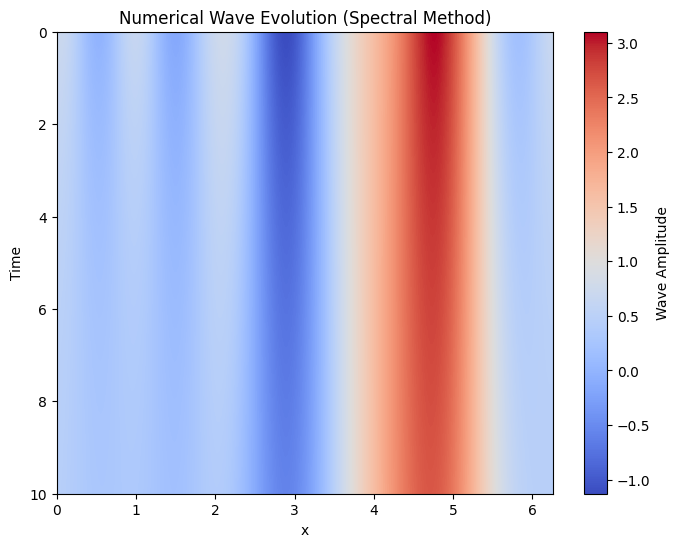

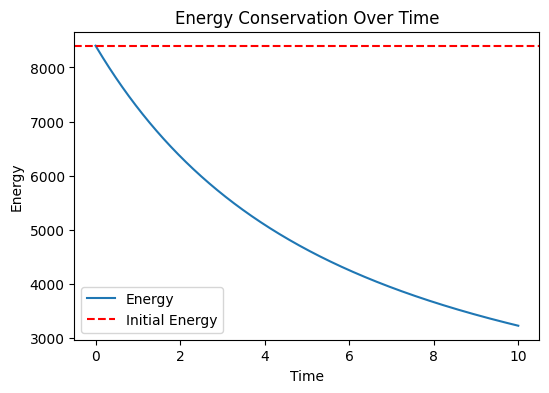

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Define Problem Parameters
# -------------------------------

L = 2 * np.pi  # Domain length
Nx = 256       # Number of spatial grid points (higher for more accuracy)
Nt = 2000      # Number of time steps
T = 10         # Total time
c = 1.0        # Wave speed
dt = T / Nt    # Time step size

# Spatial and wavenumber grids
x_vals = np.linspace(0, L, Nx, endpoint=False)  # Periodic domain
k_vals = np.fft.fftfreq(Nx, d=(L / Nx)) * 2 * np.pi  # Wavenumbers

# -------------------------------
# Step 2: Sample Initial Conditions from a Periodic GP
# -------------------------------

def periodic_kernel(x1, x2, lengthscale=0.5, variance=1.0, period=L):
    """Periodic kernel function."""
    return variance * np.exp(-2 * np.sin(np.pi * np.abs(x1 - x2) / period) ** 2 / lengthscale ** 2)

def sample_periodic_gp(Nx, L, lengthscale=0.5, variance=1.0):
    """Sample a function from a periodic Gaussian Process."""
    x_vals = np.linspace(0, L, Nx, endpoint=False)
    K = np.array([[periodic_kernel(xi, xj, lengthscale, variance) for xj in x_vals] for xi in x_vals])
    sample = np.random.multivariate_normal(mean=np.zeros(Nx), cov=K)
    return x_vals, sample

# Sample initial conditions
x_vals, u0 = sample_periodic_gp(Nx, L)

# Set initial velocity (standing wave assumption)
ut0 = np.zeros_like(u0)

# -------------------------------
# Step 3: Compute Fourier Transform
# -------------------------------

u0_hat = np.fft.fft(u0)
ut0_hat = np.fft.fft(ut0)

# -------------------------------
# Step 4: Numerical Time Evolution using Spectral Differentiation
# -------------------------------

def spectral_wave_solver(u0_hat, ut0_hat, k_vals, c, dt, Nt):
    """
    Numerically solve the 1D wave equation using a Fourier spectral method.
    
    Parameters:
    - u0_hat: Initial Fourier coefficients of displacement u(x,0).
    - ut0_hat: Initial Fourier coefficients of velocity u_t(x,0).
    - k_vals: Fourier wavenumbers.
    - c: Wave speed.
    - dt: Time step.
    - Nt: Number of time steps.
    
    Returns:
    - u_t: Solution array (Nt, Nx).
    - energy_vals: Energy over time.
    """
    
    # Storage for solution
    Nx = len(u0_hat)
    u_hat_t = np.zeros((Nt, Nx), dtype=np.complex128)
    ut_hat_t = np.zeros((Nt, Nx), dtype=np.complex128)

    # Initialize first time step
    u_hat_t[0] = u0_hat
    ut_hat_t[0] = ut0_hat

    # Leapfrog time integration (symplectic, conserves energy)
    u_hat_prev = u0_hat
    ut_hat_prev = ut0_hat

    # Compute initial energy
    energy_vals = []
    initial_energy = np.sum(np.abs(ut0_hat)**2 + c**2 * np.abs(k_vals * u0_hat)**2) * (L / Nx)
    energy_vals.append(initial_energy)

    # Time stepping
    for n in range(1, Nt):
        # Compute second derivative in Fourier space: d^2u/dx^2 = -k^2 * u_hat
        u_hat_next = (
            2 * u_hat_prev 
            - u_hat_t[n-1] 
            - (dt**2) * c**2 * (k_vals**2 * u_hat_prev)
        )

        # Update velocity in Fourier space
        ut_hat_next = (u_hat_next - u_hat_prev) / (2 * dt)

        # Store values
        u_hat_t[n] = u_hat_next
        ut_hat_t[n] = ut_hat_next
        u_hat_prev = u_hat_next

        # Compute energy at this time step
        energy_t = np.sum(np.abs(ut_hat_next)**2 + c**2 * np.abs(k_vals * u_hat_next)**2) * (L / Nx)
        energy_vals.append(energy_t)

    # Transform back to real space
    u_t = np.fft.ifft(u_hat_t, axis=1).real
    
    return u_t, energy_vals

# Run the numerical solver
u_t, energy_vals = spectral_wave_solver(u0_hat, ut0_hat, k_vals, c, dt, Nt)

# -------------------------------
# Step 5: Plot Results
# -------------------------------

# Plot the wave evolution
plt.figure(figsize=(8, 6))
plt.imshow(u_t, aspect='auto', extent=[x_vals[0], x_vals[-1], T, 0], cmap="coolwarm")
plt.colorbar(label="Wave Amplitude")
plt.xlabel("x")
plt.ylabel("Time")
plt.title("Numerical Wave Evolution (Spectral Method)")
plt.show()

# Plot the energy over time
plt.figure(figsize=(6, 4))
plt.plot(np.linspace(0, T, Nt), energy_vals, label="Energy")
plt.axhline(energy_vals[0], color="r", linestyle="--", label="Initial Energy")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy Conservation Over Time")
plt.legend()
plt.show()


0.01


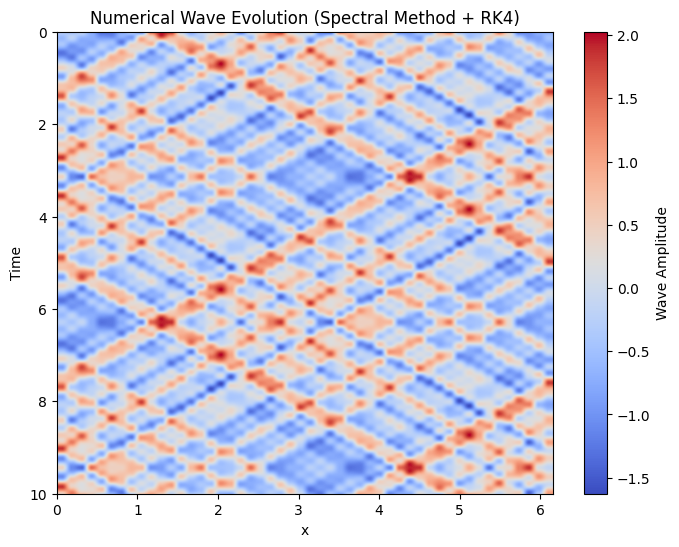

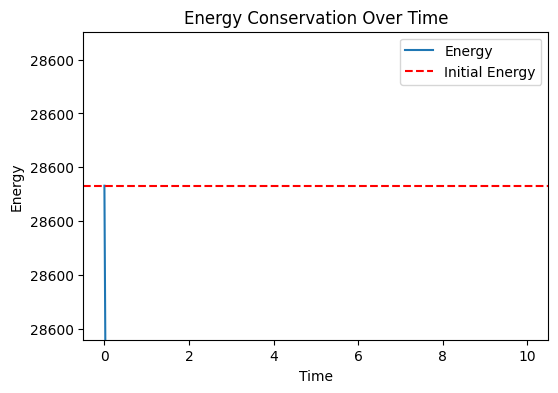

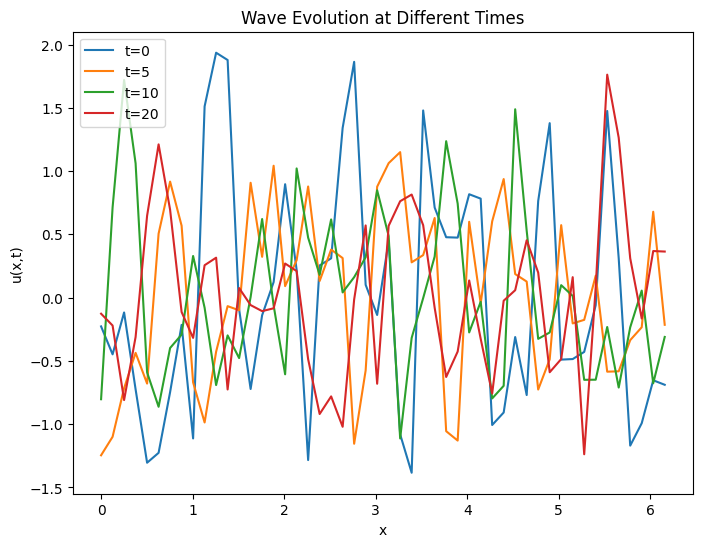

13.547018338493217


In [74]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Define Problem Parameters
# -------------------------------

L = 2 * np.pi  # Domain length
Nx = 50       # Number of spatial points (higher for more accuracy)
Nt = 1000      # Number of time steps
T = 10         # Total time
c = 1.0        # Wave speed
dt = T / Nt    # Time step size

print(dt)

# Spatial and wavenumber grids
x_vals = np.linspace(0, L, Nx, endpoint=False)  # Periodic domain
k_vals = np.fft.fftfreq(Nx, d=(L / Nx)) * 2 * np.pi  # Wavenumbers

# -------------------------------
# Step 2: Sample Initial Conditions from a Periodic GP
# -------------------------------

def periodic_kernel(x1, x2, lengthscale=0.5, variance=1.0, period=L):
    """Periodic kernel function."""
    return variance * np.exp(-2 * np.sin(np.pi * np.abs(x1 - x2) / period) ** 2 / lengthscale ** 2)

def sample_periodic_gp(Nx, L, lengthscale=0.1, variance=1):
    """Sample a function from a periodic Gaussian Process."""
    x_vals = np.linspace(0, L, Nx, endpoint=False)
    K = np.array([[periodic_kernel(xi, xj, lengthscale, variance) for xj in x_vals] for xi in x_vals])
    sample = np.random.multivariate_normal(mean=np.zeros(Nx), cov=K)
    return x_vals, sample

# Sample initial conditions
x_vals, u0 = sample_periodic_gp(Nx, L)

# Set initial velocity (zero velocity wave)
ut0 = np.zeros_like(u0)

# -------------------------------
# Step 3: Compute Fourier Transform
# -------------------------------

u0_hat = np.fft.fft(u0)
ut0_hat = np.fft.fft(ut0)

# -------------------------------
# Step 4: Numerical Time Evolution using Spectral Method + RK4
# -------------------------------

def spectral_rhs(u_hat, ut_hat, k_vals, c):
    """Compute RHS for the wave equation in Fourier space."""
    return - (c**2) * (k_vals**2) * u_hat  # Second derivative in Fourier space

def spectral_wave_solver_rk4(u0_hat, ut0_hat, k_vals, c, dt, Nt):
    """
    Numerically solve the 1D wave equation using a Fourier spectral method + RK4.

    Parameters:
    - u0_hat: Initial Fourier coefficients of displacement u(x,0).
    - ut0_hat: Initial Fourier coefficients of velocity u_t(x,0).
    - k_vals: Fourier wavenumbers.
    - c: Wave speed.
    - dt: Time step.
    - Nt: Number of time steps.

    Returns:
    - u_t: Solution array (Nt, Nx).
    - energy_vals: Energy over time.
    """
    
    Nx = len(u0_hat)
    u_hat = np.copy(u0_hat)
    ut_hat = np.copy(ut0_hat)

    # Storage for time evolution
    u_t = np.zeros((Nt, Nx), dtype=np.complex128)
    energy_vals = []

    # Compute initial energy
    initial_energy = np.sum(np.abs(ut_hat)**2 + c**2 * np.abs(k_vals * u_hat)**2) * (L / Nx)
    energy_vals.append(initial_energy)

    # Time-stepping using RK4
    for n in range(Nt):
        # Save current solution
        u_t[n] = np.fft.ifft(u_hat).real  # Transform back to real space

        # Compute Runge-Kutta 4 (RK4) stages
        k1 = dt * ut_hat
        l1 = dt * spectral_rhs(u_hat, ut_hat, k_vals, c)
        
        k2 = dt * (ut_hat + 0.5 * l1)
        l2 = dt * spectral_rhs(u_hat + 0.5 * k1, ut_hat + 0.5 * l1, k_vals, c)
        
        k3 = dt * (ut_hat + 0.5 * l2)
        l3 = dt * spectral_rhs(u_hat + 0.5 * k2, ut_hat + 0.5 * l2, k_vals, c)
        
        k4 = dt * (ut_hat + l3)
        l4 = dt * spectral_rhs(u_hat + k3, ut_hat + l3, k_vals, c)
        
        # Update values
        u_hat += (k1 + 2*k2 + 2*k3 + k4) / 6
        ut_hat += (l1 + 2*l2 + 2*l3 + l4) / 6

        # Compute energy at this time step
        energy_t = np.sum(np.abs(ut_hat)**2 + c**2 * np.abs(k_vals * u_hat)**2) * (L / Nx)
        energy_vals.append(energy_t)

    return u_t.real, energy_vals, initial_energy

# Run the solver
u_t, energy_vals, initial_energy = spectral_wave_solver_rk4(u0_hat, ut0_hat, k_vals, c, dt, Nt)

# -------------------------------
# Step 5: Plot Results
# -------------------------------

# Plot the wave evolution
plt.figure(figsize=(8, 6))
plt.imshow(u_t, aspect='auto', extent=[x_vals[0], x_vals[-1], T, 0], cmap="coolwarm", origin='upper')
plt.colorbar(label="Wave Amplitude")
plt.xlabel("x")
plt.ylabel("Time")
plt.title("Numerical Wave Evolution (Spectral Method + RK4)")
plt.show()

# Plot the energy over time
plt.figure(figsize=(6, 4))
plt.plot(np.linspace(0, T, Nt + 1), energy_vals, label="Energy")
plt.axhline(energy_vals[0], color="r", linestyle="--", label="Initial Energy")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.ylim(energy_vals[0] * 0.999999, energy_vals[0] * 1.000001)
plt.title("Energy Conservation Over Time")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))  # Remove odd units on y-axis
plt.legend()
plt.show()

#plot slices
plt.figure(figsize=(8, 6))
plt.plot(x_vals, u_t[0], label="t=0")
plt.plot(x_vals, u_t[50], label="t=5")
plt.plot(x_vals, u_t[100], label="t=10")
plt.plot(x_vals, u_t[200], label="t=20")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Wave Evolution at Different Times")
plt.legend()
plt.show()

#print maximal energy discrtepancy
print(max(initial_energy - energy_vals))


In [141]:
def wave_sample_initial_conditions_periodic_gp(x_vals, L, num_modes, zero_zero_mode=True,lengthscale=1.0, variance=1.0, period=None, noise=1e-6):
    """
    Generate smooth initial conditions using a periodic Gaussian process.

    Parameters:
        x_vals (numpy array): Spatial grid points.
        L (float): Domain length.
        lengthscale (float): Controls smoothness.
        variance (float): Controls amplitude of variations.
        period (float, optional): Period of the GP. If None, set to L.
        noise (float): Small noise term for numerical stability.

    Returns:
        u0 (numpy array): Initial condition in physical space.
        ut0 (numpy array): Time derivative of initial condition.
        u0_hat (numpy array): Fourier transform of u0.
        ut0_hat (numpy array): Fourier transform of ut0.
        x_vals (numpy array): Spatial grid points.
    """
    Nx = len(x_vals)
    x_vals_modes = np.linspace(x_vals[0], x_vals[-1], num_modes)  # Grid points for GP


    # Set period to domain length if not provided
    if period is None:
        period = L

    # Define the periodic kernel
    def periodic_kernel(x1, x2, lengthscale, variance, period):
        dist = np.abs(np.subtract.outer(x1, x2))  # Compute |x - x'|
        return variance * np.exp(-2 * (np.sin(np.pi * dist / period) ** 2) / lengthscale**2)

    # Compute covariance matrix
    K = periodic_kernel(x_vals_modes, x_vals_modes, lengthscale, variance, period)
    K += noise * np.eye(num_modes)  # Add small noise for numerical stability

    # Sample from the GP prior
    u0 = np.random.multivariate_normal(mean=np.zeros(num_modes), cov=K)
    ut0 = np.random.multivariate_normal(mean=np.zeros(num_modes), cov=K)  # Independent sample for velocity

    # Convert to Fourier space
    u0_hat = np.fft.fft(u0)
    ut0_hat = np.fft.fft(ut0)

    #zero out the zero-th mode
    if zero_zero_mode:
        u0_hat[0] = 0
        ut0_hat[0] = 0

    # Ensure conjugate symmetry for real IFFT using provided function
    u0_hat = enforce_hermitian_symmetry(u0_hat)
    ut0_hat = enforce_hermitian_symmetry(ut0_hat)

    # Pad higher modes with zeros
    u0_hat_padded = np.zeros(Nx, dtype=complex)
    ut0_hat_padded = np.zeros(Nx, dtype=complex)

    # Copy non-zero modes
    u0_hat_padded[:num_modes//2] = u0_hat[:num_modes//2]
    u0_hat_padded[-num_modes//2:] = u0_hat[-num_modes//2:]
    ut0_hat_padded[:num_modes//2] = ut0_hat[:num_modes//2]
    ut0_hat_padded[-num_modes//2:] = ut0_hat[-num_modes//2:]

    # Transform back to physical space with padded spectrum
    u0 = np.fft.ifft(u0_hat_padded).real * Nx/num_modes
    ut0 = np.fft.ifft(ut0_hat_padded).real * Nx/num_modes

    # Update Fourier coefficients
    u0_hat = np.fft.fft(u0) 
    ut0_hat = np.fft.fft(ut0)

    return u0, ut0, u0_hat, ut0_hat, x_vals

def wave_sample_initial_conditions_sinusoidal(x_vals, L):
    """Generate smooth initial conditions as a sum of sinusoids, then transform to Fourier space."""
    Nx = len(x_vals)

    # Create initial condition as sum of sinusoids
    k_max = 10  
    amplitudes = np.random.randn(k_max) * np.exp(-np.linspace(0, k_max, k_max)**2 / 10)
    phases = np.random.uniform(0, 2 * np.pi, k_max)
    
    u0 = np.sum([a * np.sin(k * np.pi * x_vals / (L/2) + p) for k, a, p in zip(range(1, k_max + 1), amplitudes, phases)], axis=0)
    ut0 = np.sum([a * np.cos(k * np.pi * x_vals / (L/2) + p) for k, a, p in zip(range(1, k_max + 1), amplitudes, phases)], axis=0)

    # Convert to Fourier space
    u0_hat = np.fft.fft(u0)
    ut0_hat = np.fft.fft(ut0)

    # print("Before enforcement:", np.max(np.abs(u0_hat.imag)))

    # Ensure conjugate symmetry for real IFFT
    u0_hat = enforce_hermitian_symmetry(u0_hat)
    ut0_hat = enforce_hermitian_symmetry(ut0_hat)

    #recalculate u0 and ut0
    u0 = np.fft.ifft(u0_hat).real
    ut0 = np.fft.ifft(ut0_hat).real

    # print("After enforcement:", np.max(np.abs(u0_hat.imag)))

    return u0, ut0, u0_hat, ut0_hat, x_vals


def enforce_hermitian_symmetry(u_hat):
    N = len(u_hat)
    # Ensure the DC component is real
    u_hat[0] = np.real(u_hat[0])
    
    if N % 2 == 0:
        # For even N, ensure Nyquist frequency is real
        u_hat[N//2] = np.real(u_hat[N//2])
        # Loop over frequencies 1 ... N//2 - 1
        for k in range(1, N//2):
            avg = 0.5 * (u_hat[k] + np.conj(u_hat[-k]))
            u_hat[k] = avg
            u_hat[-k] = np.conj(avg)
    else:
        # For odd N, loop over frequencies 1 ... (N-1)//2
        for k in range(1, (N+1)//2):
            avg = 0.5 * (u_hat[k] + np.conj(u_hat[-k]))
            u_hat[k] = avg
            u_hat[-k] = np.conj(avg)
    
    return u_hat

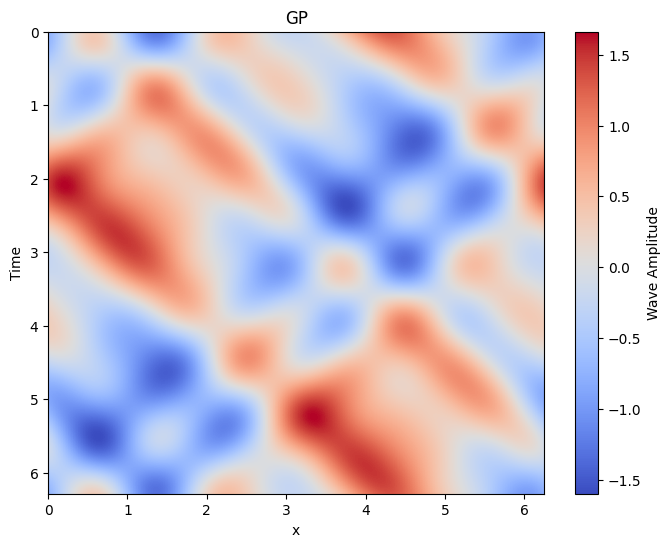

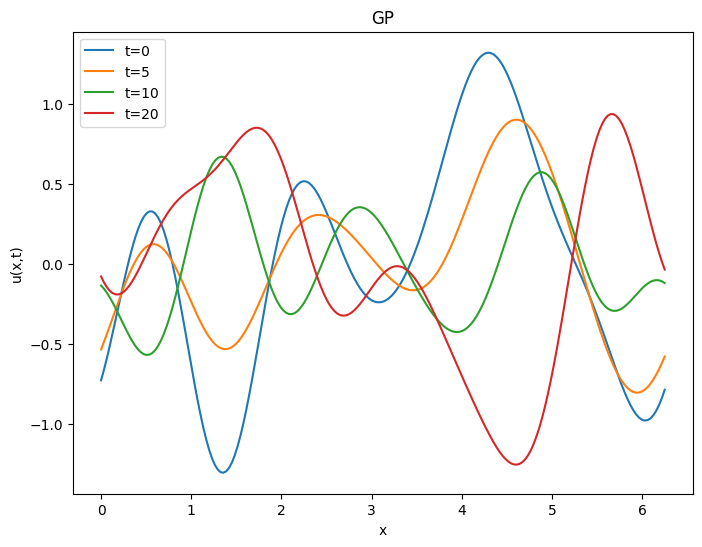

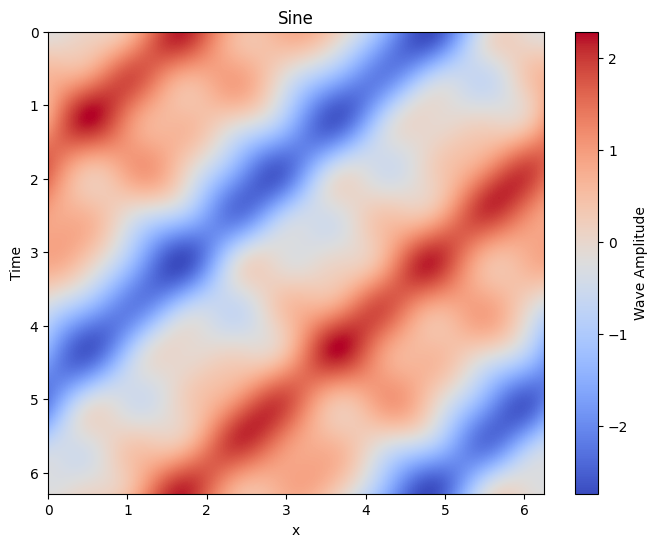

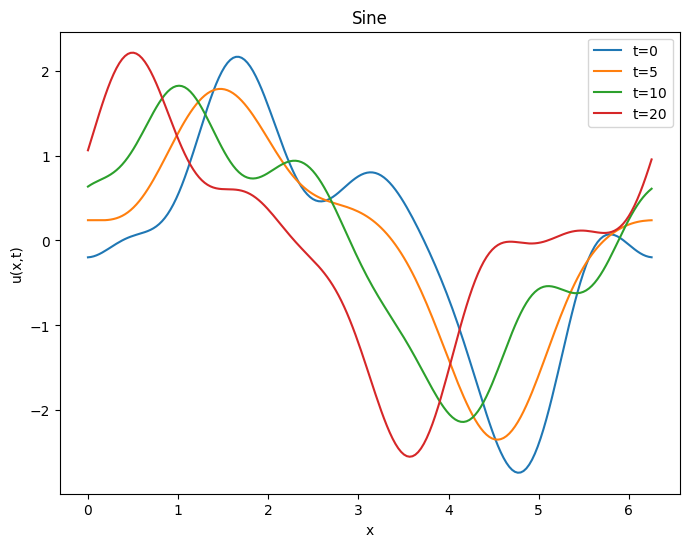

(1000,)
(1000, 199)


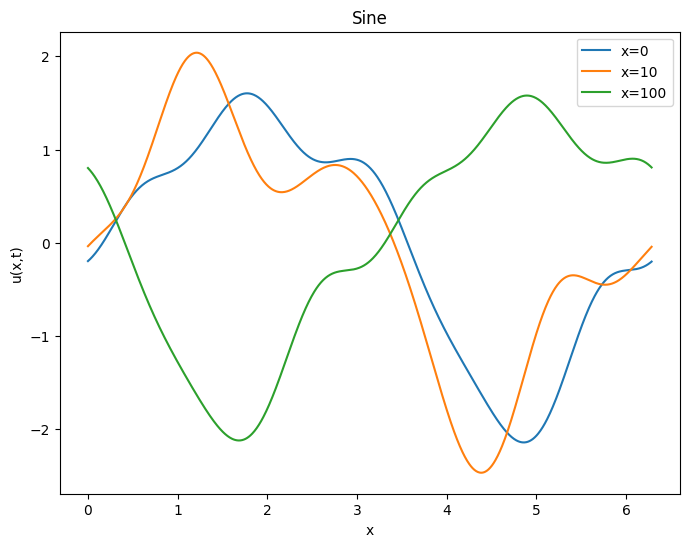

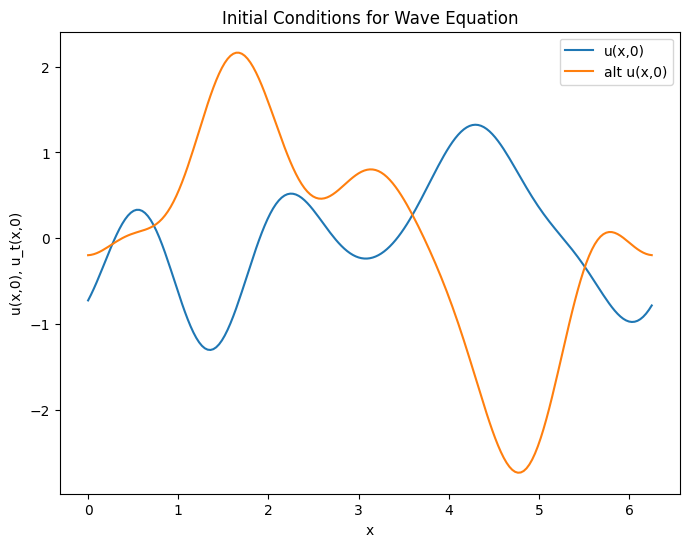

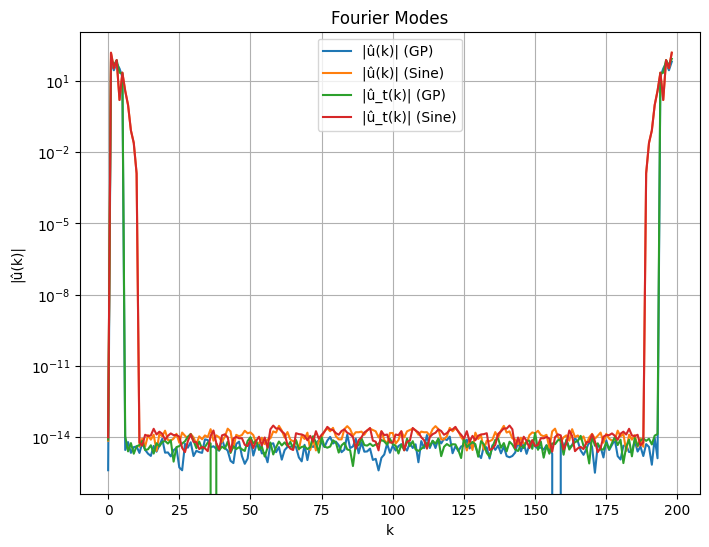

[6.54541004e-04 5.14526795e-04 3.80565770e-04 2.52839012e-04
 1.31504568e-04 1.66972605e-05 9.14714814e-05 1.92913751e-04
 2.87565269e-04 3.75385450e-04 4.56357445e-04 5.30488151e-04
 5.97808181e-04 6.58371816e-04 7.12256915e-04 7.59564796e-04
 8.00420092e-04 8.34970563e-04 8.63386891e-04 8.85862436e-04
 9.02612960e-04 9.13876328e-04 9.19912170e-04 9.21001523e-04
 9.17446432e-04 9.09569534e-04 8.97713605e-04 8.82241079e-04
 8.63533546e-04 8.41991218e-04 8.18032367e-04 7.92092739e-04
 7.64624945e-04 7.36097825e-04 7.06995784e-04 6.77818115e-04
 6.49078287e-04 6.21303221e-04 5.95032542e-04 5.70817807e-04
 5.49221720e-04 5.30817323e-04 5.16187174e-04 5.05922506e-04
 5.00622370e-04 5.00892767e-04 5.07345758e-04 5.20598572e-04
 5.41272699e-04 5.69992962e-04 6.07386600e-04 6.54082321e-04
 7.10709366e-04 7.77896552e-04 8.56271323e-04 9.46458786e-04
 1.04908075e-03 1.16475478e-03 1.29409319e-03 1.43770212e-03
 1.59618058e-03 1.77011947e-03 1.96010060e-03 2.16669584e-03
 2.39046605e-03 2.631960

In [150]:
k_vals = np.fft.fftfreq(Nx, d=(L / Nx)) * 2 * np.pi  # Wavenumbers
Nt = 1000      # Number of time steps
c = 1.0
T = L/c         # Total time        # Wave speed
dt = T / Nt    # Time step size
Nx = 199
L = 2 * np.pi
num_modes = 10
x_vals = np.linspace(0, L, Nx, endpoint=False)
x_vals_alt = np.linspace(0, L, num_modes, endpoint=False)
t_vals = np.linspace(0, T, Nt)

u0, ut0, u0_hat, ut0_hat, x_vals = wave_sample_initial_conditions_periodic_gp(x_vals, L, num_modes, lengthscale=0.1, variance=1.0)
u_t, energy_vals, initial_energy = spectral_wave_solver_rk4(u0_hat, ut0_hat, k_vals, c, dt, Nt)
# Plot the wave evolution
plt.figure(figsize=(8, 6))
plt.imshow(u_t, aspect='auto', extent=[x_vals[0], x_vals[-1], T, 0], cmap="coolwarm", origin='upper')
plt.colorbar(label="Wave Amplitude")
plt.xlabel("x")
plt.ylabel("Time")
plt.title("GP")
plt.show()

#plot slices
plt.figure(figsize=(8, 6))
plt.plot(x_vals, u_t[0], label="t=0")
plt.plot(x_vals, u_t[50], label="t=5")
plt.plot(x_vals, u_t[100], label="t=10")
plt.plot(x_vals, u_t[200], label="t=20")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("GP")
plt.legend()
plt.show()

u0_alt, ut0_alt, u0_hat_alt, ut0_hat_alt, x_vals = wave_sample_initial_conditions_sinusoidal(x_vals, L)
u_t, energy_vals, initial_energy = spectral_wave_solver_rk4(u0_hat_alt, ut0_hat_alt, k_vals, c, dt, Nt)
# Plot the wave evolution
plt.figure(figsize=(8, 6))
plt.imshow(u_t, aspect='auto', extent=[x_vals[0], x_vals[-1], T, 0], cmap="coolwarm", origin='upper')
plt.colorbar(label="Wave Amplitude")
plt.xlabel("x")
plt.ylabel("Time")
plt.title("Sine")
plt.show()

#plot slices
plt.figure(figsize=(8, 6))
plt.plot(x_vals, u_t[0], label="t=0")
plt.plot(x_vals, u_t[50], label="t=5")
plt.plot(x_vals, u_t[100], label="t=10")
plt.plot(x_vals, u_t[200], label="t=20")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Sine")
plt.legend()
plt.show()

#plot slices
print(t_vals.shape)
print(u_t.shape)
plt.figure(figsize=(8, 6))
plt.plot(t_vals, u_t[:,0], label="x=0")
plt.plot(t_vals, u_t[:,10], label="x=10")
plt.plot(t_vals, u_t[:,100], label="x=100")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Sine")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x_vals, u0, label="u(x,0)")
plt.plot(x_vals, u0_alt, label="alt u(x,0)")
plt.xlabel("x")
plt.ylabel("u(x,0), u_t(x,0)")
plt.title("Initial Conditions for Wave Equation")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
# Plot absolute value of Fourier coefficients
plt.semilogy(np.abs(u0_hat), label='|û(k)| (GP)')
plt.semilogy(np.abs(u0_hat_alt), label='|û(k)| (Sine)')
plt.semilogy(np.abs(ut0_hat), label='|û_t(k)| (GP)')
plt.semilogy(np.abs(ut0_hat_alt), label='|û_t(k)| (Sine)')
plt.xlabel('k')
plt.ylabel('|û(k)|')
plt.title('Fourier Modes')
plt.grid(True)
plt.legend()
plt.show()

#check for peridicity in space
diff = u_t[:,0] - u_t[:,-1]
print(np.abs(diff))
